In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
import seaborn as sns
import plottools as pt
from scipy.integrate import quad

import pandas as pd
import itertools
import gmpy2 as gmp
from importlib import reload

#### Plots of spectral features

In [20]:
def pole(m, z):
    return 1 / (m - z)

def analytic_dft(m, z, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(np.exp(z-m) - 1)
    pole2 = 1/(np.exp(z+m) - 1)
    return prefactor * (pole1 + pole2)

def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)
#     return prefactor * pole1

def unstable_pole(z, m, gamma):
    mpi = 0.140
    return 0.25*(1 - 4*mpi**2/z**2)**0.5/(z - (m - 1j*gamma))

def kinematic_feature(z):
    z = z + 0*1j
    return -1*(0.25 - z)**0.5

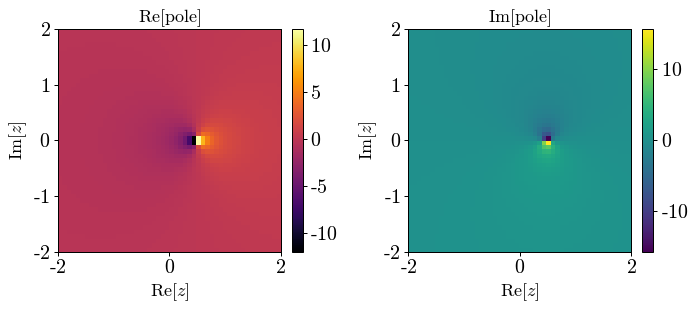

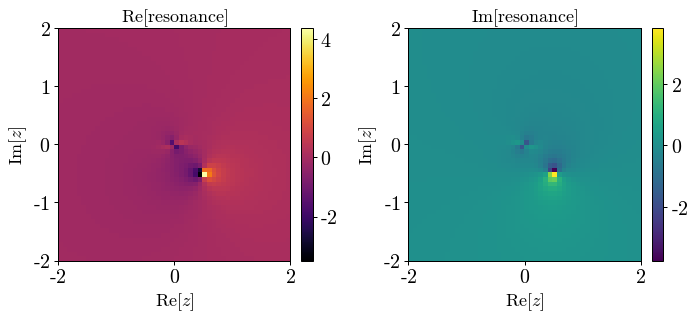

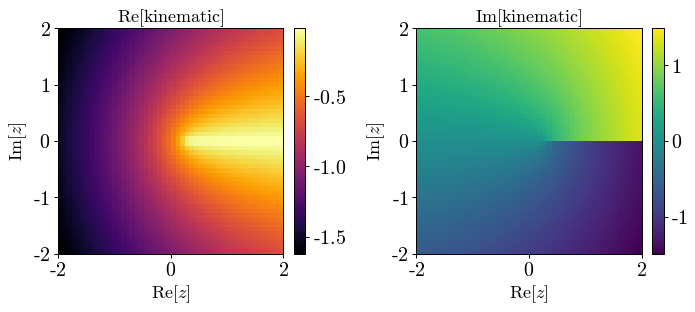

In [21]:
reload(pt)
f, ax = pt.plot_fn_CC_2D(lambda z :  pole(z, 0.5), fname = r'\mathrm{pole}')
f, ax = pt.plot_fn_CC_2D(lambda z :  unstable_pole(z, 0.5, 0.5), fname = r'\mathrm{resonance}')
f, ax = pt.plot_fn_CC_2D(lambda z :  kinematic_feature(z), fname = r'\mathrm{kinematic}')

In [22]:
def matsubara(beta, boson=False):
    n = np.arange(beta)
    if boson:
         return 2*n*np.pi/beta * 1j
    return (2*n+1)*np.pi/beta * 1j

def plot_imag_data(freq, ng, axarr):
    """
    Plots imaginary-domain data.
    """
    ax1, ax2, ax3 = axarr
    plt.errorbar(ax1, freq.real, freq.imag, fmt='.')
    plt.errorbar(ax2, freq.imag, ng.real, fmt='.')
    plt.errorbar(ax3, freq.imag, ng.imag, fmt='.')
    ax1.set_title("Matsubara frequencies")
    ax2.set_title(r"$\Re\,G_E(i\omega)$")
    ax3.set_title(r"$\Im\,G_E(i\omega)$")
    return axarr

def plot_moebius(z, ax, **kwargs):
    h = nv.moebius(z)
    plt.errorbar(ax, h.real, h.imag, fmt='.', **kwargs)    
    return ax

def plot_unit_circle(ax, **kwargs):
    x = np.linspace(-1, 1, num=100)
    plt.errorbar(ax, x, np.sqrt(1-x**2), **kwargs)
    plt.errorbar(ax, x, -np.sqrt(1-x**2), **kwargs)
    return ax

ValueError: 'x' and 'y' must have the same size

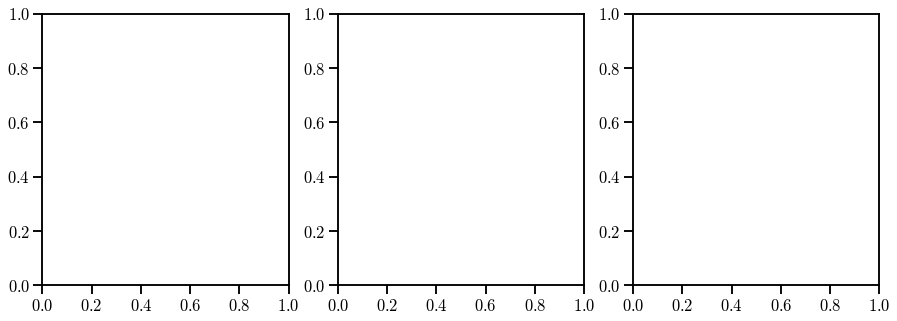

In [8]:
beta = 48
m = 0.05

freq_b = matsubara(beta, boson=True)
freq_f = matsubara(beta, boson=False)

ng_b = np.zeros(len(freq_b))
for mm in [0.05, 0.1]:
    ng_b = ng_b + analytic_ft(freq_b, mm, beta)

# ng_b = analytic_ft(freq_b, m, beta) + analytic_ft(freq_b, 2*m, beta) + analytic_ft(freq_b, 3*m, beta)
ng_f = analytic_ft(freq_f, m, beta) + analytic_ft(freq_f, 2*m, beta)

# Plot imaginary-domain data
with sns.plotting_context("talk"):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    plot_imag_data(freq_b, ng_b, axarr)    
    plot_imag_data(freq_f, ng_f, axarr)
    fig.tight_layout()
    
# Plot Moebius tranform of imaginary-domain data
# The result should lie within the unit disk
with sns.plotting_context("talk"):

    fig, axarr = Plt.subplots(ncols=2, figsize=(10,5))
    ax1, ax2 = axarr
    
    plot_unit_circle(ax1, color='k')
    plot_unit_circle(ax2, color='k')

    plot_moebius(freq_b, ax=ax1)
    plot_moebius(freq_f, ax=ax1)

    plot_moebius(ng_b, ax=ax2)
    plot_moebius(ng_f, ax=ax2)

    ax1.set_title(r"$h(i\omega)$")
    ax2.set_title(r"$h(G_E(i\omega))$")
    
    fig.tight_layout()    

## Initialize parameters and plot original function

In [2]:
zbounds = np.array([[-3, 3], [0, 6]])        # [xbounds, ybounds]
def gaussian(z0, sigma):
    """Returns function handle for a Gaussian centered at (x0, y0) with std sigma"""
    def f(z):
        # return (1j) * np.exp(- np.abs(z - z0) ** 2 / (2 * (sigma ** 2))) / (2 * np.pi * sigma)
        return np.exp(- np.abs(z - z0) ** 2 / (2 * (sigma ** 2))) / (2 * np.pi * sigma)
    return f

In [3]:
dz = 0.1
x = np.arange(zbounds[0, 0], zbounds[0, 1], dz)
y = np.arange(zbounds[1, 0], zbounds[1, 1], dz)
zdomain = np.array([[x[i] + (1j) * y[j] for j in range(len(x))] for i in range(len(y))], dtype = np.complex64)
# f_test = gaussian(0.0 + 3.0 * (1j), 1.0)
z0 = 0.0 + 3.0 * (1j)
f_test = gaussian(z0, 1.0)    # see if making it imaginary fixes precision issues

In [4]:
# choose points to sample. The algorithm is having some issues when the points have equal values.
# sample_bounds = np.array([[-1, 1], [2, 4]])
sample_bounds = np.array([[-2, 2], [1, 5]])
dsample = 0.5
# dsample = 0.25
# dsample = 0.1
sx = np.arange(sample_bounds[0, 0], sample_bounds[0, 1], dsample)
sy = np.arange(sample_bounds[1, 0], sample_bounds[1, 1], dsample)
# sample_domain = np.array([[sx[i] + (1j) * sy[j] for i in range(len(sx))] for j in range(len(sy))], dtype = np.complex64)
r = 1.0
# r = 0.25
sample_domain = []
for j in range(len(sy)):
    for i in range(len(sx)):
        if ((sx[i] - np.real(z0)) ** 2 + (sy[j] - np.imag(z0)) ** 2 < r ** 2):
            sample_domain.append(sx[i] + (1j) * sy[j])
sample_domain = np.array(sample_domain, dtype = np.complex64)
samples = np.array(list(map(f_test, sample_domain)))

In [5]:
# fake input to use to see what we get out
freqs = sample_domain.flatten()
C = samples.flatten()

# # for test: shuffle the frequency values
# tmp_pair = [freqs[4], C[4]]
# freqs[4], C[4] = freqs[0], C[0]
# freqs[0], C[0] = tmp_pair[0], tmp_pair[1]

# Only use unique function values to see what happens
# _, unique_idxs = np.unique(C, return_index = True)
# freqs = freqs[unique_idxs]
# C = C[unique_idxs]

In [6]:
# choose my own input
# freqs = [-1.2 + 5.j, -1.03 + 3.2j, -0.35 + 1.2j, -0.8 + 1.6j, 0.42 + 0.5j, 0.6 + 4.4j, 1.4 + 2.8j, 1.72 + 2.2j, 0.1 + 5.7j]
# C = np.array(list(map(f_test, freqs)))

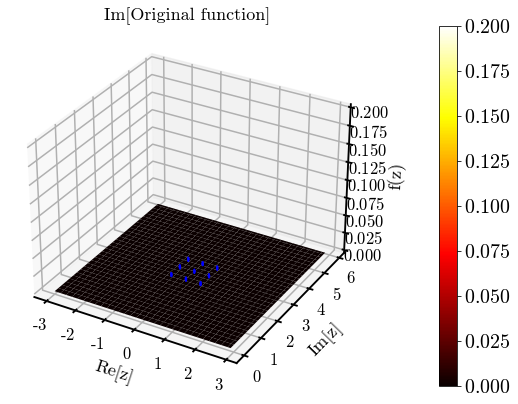

In [23]:
epsilon = 1e-3 + 0j
C_plot = np.array([tmp + epsilon for tmp in C])
f_plot = np.array(list(map(f_test, zdomain)))

fig, ax3, graph3 = pt.plot_complex3D(x, y, np.imag(f_plot), title = 'Im[Original function]', alpha = 1.0, vmin = 0.0, vmax = 0.2, \
    zbounds = (0., 0.2), fig_size = (20, 5))
pt.add_points(ax3, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
fig = pt.add_colorbar(fig, graph3)

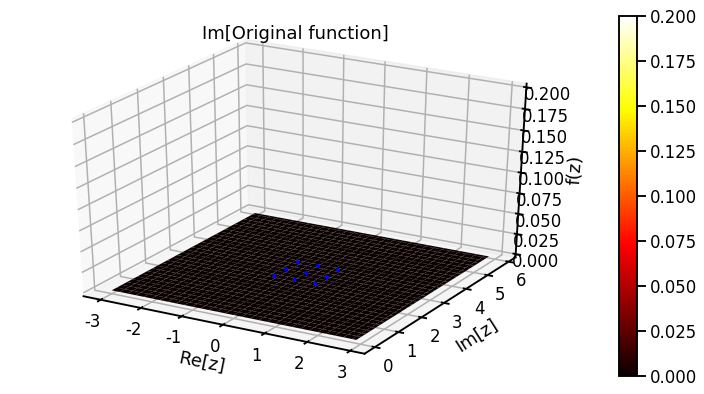

In [7]:
epsilon = 1e-3 + 0j
C_plot = np.array([tmp + epsilon for tmp in C])
f_plot = np.array(list(map(f_test, zdomain)))
with sns.plotting_context('talk'):
    fig = plt.figure(figsize = (10, 5))
    ax3 = Axes3D(fig)
    # _, graph3 = plot_complex3D(x, y, np.real(f_plot), ax = ax3, title = 'Re[Original function]', alpha = 1.0, vmin = 0.0, vmax = 0.2)
    _, graph3 = pt.plot_complex3D(x, y, np.imag(f_plot), ax = ax3, title = 'Im[Original function]', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
    # add_points(ax3, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    add_points(ax3, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph3)

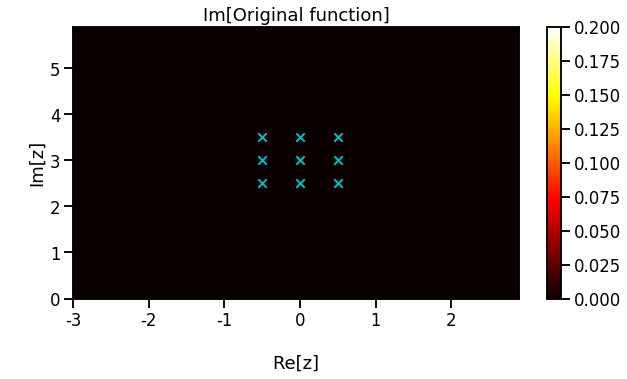

In [8]:
with sns.plotting_context('talk'):
    fig, ax2 = plt.subplots(1, figsize = (10, 5))
    # _, graph = plot_complex2D(ax2, x, y, np.real(f_plot), title = 'Re[Original function]', col = 'hot', vmin = 0.0, vmax = 0.2)
    # add_points(ax2, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    _, graph = plot_complex2D(ax2, x, y, np.imag(f_plot), title = 'Im[Original function]', col = 'hot', vmin = 0.0, vmax = 0.2)
    add_points(ax2, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'c', lw = 12, size = 2)
    plt.colorbar(graph)

## Sample from function and perform analytic continuation

In [9]:
theta_mp1 = lambda z : 0
# theta_mp1 = hardy(1)
Y = np.array([gmp.mpc(float(np.real(x)), float(np.imag(x))) for x in freqs])
C_gmp = np.array([gmp.mpc(float(np.real(x)), float(np.imag(x))) for x in C])
zinterp = zdomain.flatten()
# x_interp, y_interp = np.real(zinterp), np.imag(zinterp)

In [10]:
# determine is there is a Nevanlinna interpolant
lambdas = np.array([h(z) for z in C_gmp])
print(is_soluble(Y, lambdas))
# Pick = construct_Pick(Y, lambdas)
# Pick_np = np.complex64(Pick)
# eigs, _ = np.linalg.eigh(Pick_np)

False


In [11]:
phis = construct_phis(Y, lambdas)
cont = analytic_continuation(Y, phis, zinterp, theta_mp1)
# cont = analytic_continuation(Y, phis, freqs, theta_mp1)
cont_float = np.array([np.complex(x) for x in cont])

k: 0
abcd|_{Y_k} is: [[mpc('0.009900990099009900990099009900990099009915-0.09900990099009900990099009900990099009888j',(128,128))
  mpc('-0.9697377351859379050466814488719322535839-0.2441489810678057472203859026541761923148j',(128,128))]
 [mpc('0.01457180272764474818967502552148346207483+0.09843095379135826532363564743934157156562j',(128,128))
  mpc('1.0+0.0j',(128,128))]]
num is: 0.008428971901617296888987055951420029272082-0.03132417848275744824701741701489821284026j
denom is: -0.003206094080535785112496690816408852116926-0.0003732219943004734423771966413761413065309j
phi_{k + 1}: -1.471752075492119567157177577669829669788+9.941526332927184797687200391373498728124j
k: 1
abcd|_{Y_k} is: [[mpc('0.961538461538461538461538461538461538467+0.1923076923076923076923076923076923076711j',(128,128))
  mpc('0.8854884028580545726948117964818240529857+0.4212466616394166617593482619505410029584j',(128,128))]
 [mpc('-0.9793918571149029370103448359641995115808+0.04827060964482515981831693546133629002

0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0

0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0

0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0

0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0.0+0.0j
0

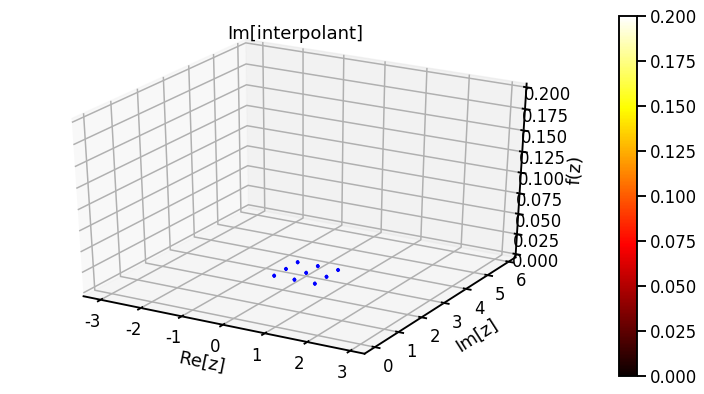

In [12]:
cont_plot = np.reshape(cont_float, zdomain.shape)
with sns.plotting_context('talk'):
    fig = plt.figure(figsize = (10, 5))
    ax4 = Axes3D(fig)
    # _, graph4 = plot_complex3D(ax4, x, y, np.real(cont_plot), title = 'Re[interpolant]', alpha = 1.0, vmin = 0.0, vmax = 0.2)
    # add_points(ax4, np.real(freqs), np.imag(freqs), C_plot, col = 'b')
    _, graph4 = plot_complex3D(ax4, x, y, np.imag(cont_plot), title = 'Im[interpolant]', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
    add_points(ax4, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph4)

In [13]:
x[0], y[0], np.imag(cont_plot[0, 0])    # should be > 0

(-3.0, 0.0, 1.0)

In [14]:
np.where(np.imag(cont_plot) < 0.)[0]

array([], dtype=int64)

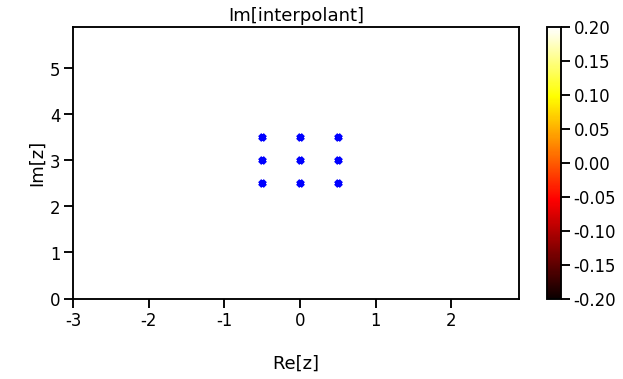

In [15]:
with sns.plotting_context('talk'):
    fig, ax5 = plt.subplots(1, figsize = (10, 5))
    # _, graph5 = plot_complex2D(ax5, x, y, np.real(cont_plot), title = 'Re[interpolant]', vmin = 0.0, vmax = 0.2)
    # add_points(ax5, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    _, graph5 = plot_complex2D(ax5, x, y, np.imag(cont_plot), title = 'Im[interpolant]', vmin = -0.2, vmax = 0.2)
    add_points(ax5, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph5)

In [16]:
# # Sanity check: this should vanish if it's a valid continuation
# Ntest = 10
# for seed in range(50):
#     np.random.seed(seed)
#     pts = np.random.choice(len(phis), size = Ntest, replace = False)
#     print(pts)
#     phi_sub = construct_phis(Y[pts], lambdas[pts])
#     cont_sample_pts = analytic_continuation(Y[pts], phi_sub, freqs[pts], theta_mp1)
# #     cont_sample_pts = analytic_continuation(Y[pts], phi_sub, Y[pts], theta_mp1)
#     print(np.array([np.complex(x) for x in cont_sample_pts]) - C[pts])

In [17]:
# # Sanity check: this should vanish if it's a valid continuation
# # pts = [61, 49]    # fixed this problem
# pts = [17, 33]
# print(pts)
# print(C[pts])
# phi_sub = construct_phis(Y[pts], lambdas[pts])
# print(phi_sub)
# cont_sample_pts = analytic_continuation(Y[pts], phi_sub, Y[pts], theta_mp1)
# print(np.array([np.complex(x) for x in cont_sample_pts]) - C[pts])

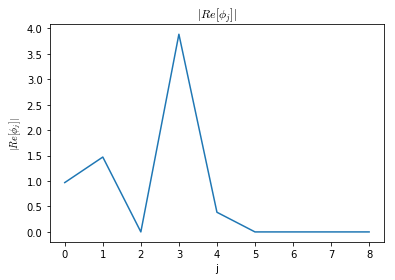

In [18]:
plt.figure()
# plt.plot(np.sort([np.abs(float(phi.real)) for phi in phis]))
plt.plot([np.abs(float(phi.real)) for phi in phis])
plt.title('$|Re[\phi_j]|$')
plt.xlabel('j')
plt.ylabel('$|Re[\phi_j]|$')
# plt.yscale('log')
# plt.ylim((-1, 1))
# plt.ylim(())
plt.show()

In [19]:
# C_gmp

In [20]:
# Y

In [21]:
# phis

In [22]:
# lambdas

In [23]:
# xi01 = (Y[1] - Y[0]) / (Y[1] - conj(Y[0]))
# c = conj(phis[0]) * xi01

In [24]:
# print(c)

In [25]:
# num = lambdas[1] - phis[0]
# denom = xi01 - lambdas[1] * c
# print(num)
# print(denom)
# print(num / denom)

In [26]:
# Pick = construct_Pick(Y[:2], lambdas[:2])

In [27]:
# Pick_np = np.complex64(Pick)

In [28]:
# Pick_np

In [29]:
# np.linalg.eigh(Pick_np)

In [30]:
# # Sanity check: this should be nonnegative
# test_freq = np.array([-3. + 0. * (1j)])
# phi_sub = construct_phis(Y, lambdas)
# test_cont = analytic_continuation(Y, phis, test_freq, theta_mp1)
# print(test_cont)

## Play with continued fractions and see what's up

In [31]:
# test_pt = [gmp.mpc(2. + 2. * 1j), gmp.mpc(0.5 * 1j)]    # Look at expansion with (Y_i, phi_i)
# def f_single_pt(z):
#     xi0 = (z - test_pt[0]) / (z - conj(test_pt[0]))
#     num = xi0 * hardy(1)(z) + test_pt[1]
#     denom = conj(test_pt[1]) * xi0 * hardy(1)(z) + 1
#     return np.complex64(num / denom)
# # plot_data = np.array(list(map(f_single_pt, zdomain)))
# plot_data = np.array(list(map(lambda x : np.complex64(hardy(1)(x)), zdomain)))
# with sns.plotting_context('talk'):
#     fig = plt.figure(figsize = (10, 5))
#     ax6 = Axes3D(fig)
#     _, graph6 = plot_complex3D(ax6, x, y, np.real(plot_data), title = 'Hardy space basis element 0', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
#     plt.colorbar(graph6)

In [32]:
# test_pt = [gmp.mpc(2. + 2. * 1j), gmp.mpc(0.5 * 1j)]    # Look at expansion with (Y_i, phi_i)
# def f_single_pt(z):
#     xi0 = (z - test_pt[0]) / (z - conj(test_pt[0]))
#     num = xi0 * hardy(1)(z) + test_pt[1]
#     denom = conj(test_pt[1]) * xi0 * hardy(1)(z) + 1
#     return np.complex64(num / denom)
# plot_data = np.array(list(map(f_single_pt, zdomain)))
# with sns.plotting_context('talk'):
#     fig = plt.figure(figsize = (10, 5))
#     ax6 = Axes3D(fig)
#     _, graph6 = plot_complex3D(ax6, x, y, np.real(plot_data), title = 'Sample theta1 with 1 point constrained', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
#     plt.colorbar(graph6)

In [33]:
# with sns.plotting_context('talk'):
#     fig, ax7 = plt.subplots(1, figsize = (10, 5))
#     _, graph = plot_complex2D(ax7, x, y, np.real(plot_data), title = 'Im[Original function]', col = 'hot', vmin = -1.0, vmax = 1.0)
#     plt.colorbar(graph)